In [ ]:
!python3 -m pip install umap-learn
!python3 -m pip install hdbscan

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
from scipy.stats import mode
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD # LSA

from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import confusion_matrix

from umap import UMAP
from hdbscan import HDBSCAN

In [ ]:
# X = np.array(dataset.data, dtype='int64')[::30]
# y = np.array(dataset.target, dtype='int64')[::30]
# print(f'X.shape: {X.shape}  y.shape: {y.shape}')

In [ ]:
# p = np.random.permutation(len(X))
# X, y = X[p], y[p] # unison shuffle

In [2]:
def cut(data, target, size):
    X_, X, y_, y = train_test_split(data, target, test_size=size, random_state=42, stratify=target)
    return X, y


def show_10(X, y):
    fig, axes = plt.subplots(1, 8, figsize=(10,4))
    for x, d, ax in zip(X, y, axes.flat):
        ax.set(title=d, xticks=[], yticks=[])
        ax.imshow((255-x).reshape((28,28)), cmap='gray')


def scatter_2dim(X_projected, y, title):
    plt.figure(figsize=(8,5))
    plt.scatter(X_projected[:,0], X_projected[:,1], c=y)
    plt.title(title)
    plt.colorbar();


def show_report(X, y, X_projected, clusters):
    
    p = np.zeros_like(clusters)
    for c in range(10):
        if np.sum(clusters == c):
            p[clusters == c] = mode(y[clusters == c])[0][0]
            # p[clusters==c] = np.argmax(np.bincount(y[clusters==c]))

    print(f'X.shape: {X.shape}')
    print(f'X_projected.shape: {X_projected.shape}')
    print(f'accuracy_score: {accuracy_score(y, p):.3f}')
    print(f'silhouette_score: {silhouette_score(X_projected, clusters):.3f}')
    print(f'homogeneity_score: {homogeneity_score(y, p):.3f}')
    print(f'completeness_score: {completeness_score(y, p):.3f}')
    print(f'v_measure_score: {v_measure_score(y, p):.3f}')

    mat = confusion_matrix(y, p)
    plt.figure(figsize=(4,4))
    sns.heatmap(mat.T, square=True, cmap='OrRd')
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title('confusion matrix')

    fig, axes = plt.subplots(1, 10, figsize=(8,2))
    fig.patch.set_visible(False)
    fig.suptitle("clusters' centers")
    
    for c, ax in enumerate(axes.flat):
        if np.sum(clusters == c):
            d = mode(y[clusters == c])[0][0]
            x = X[clusters == c].mean(axis=0)
            ax.axis('off')
            ax.set(title=d, xticks=[], yticks=[])
            ax.imshow(255 - x.reshape((28,28)), cmap='gray')


def plot_components(data):
    
    thumb_frac = 0.05
    images = data.reshape((-1, 28, 28))
    model = UMAP(n_components=2, random_state=42)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2: continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap='gray_r'),proj[i])
            ax.add_artist(imagebox)

In [3]:
dataset = fetch_openml("mnist_784")
data = np.array(dataset.data, dtype='int64')
target = np.array(dataset.target, dtype='int64')
print(f'X.shape: {data.shape}  y.shape: {target.shape}')

X.shape: (70000, 784)  y.shape: (70000,)


In [4]:
X, y = data, target  # 100%
# X, y = cut(data, target, 0.05)
X.shape, y.shape, np.sum(y == 9)

((70000, 784), (70000,), 6958)

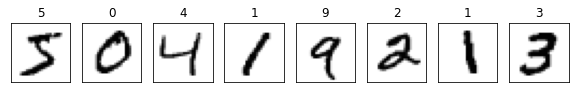

In [6]:
show_10(X, y)

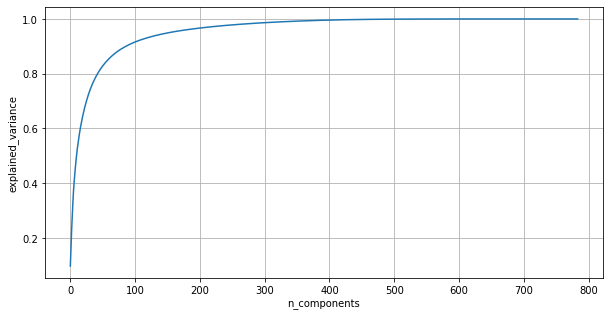

In [7]:
pca = PCA(n_components=784).fit(X)
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.xlabel('n_components')
plt.ylabel('explained_variance')
plt.grid();

X.shape: (70000, 784)
X_projected.shape: (70000, 150)
X_reconstructed.shape: (70000, 784)


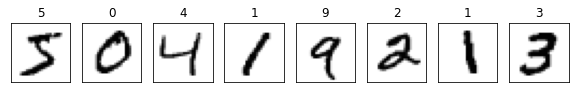

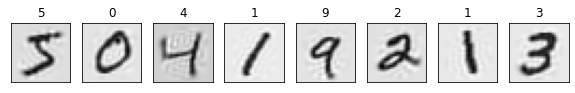

In [8]:
pca = PCA(n_components=150).fit(X)
X_projected = pca.transform(X)
X_reconstructed = pca.inverse_transform(X_projected)

print(f'X.shape: {X.shape}')
print(f'X_projected.shape: {X_projected.shape}')
print(f'X_reconstructed.shape: {X_reconstructed.shape}')

show_10(X, y)
show_10(X_reconstructed, y)

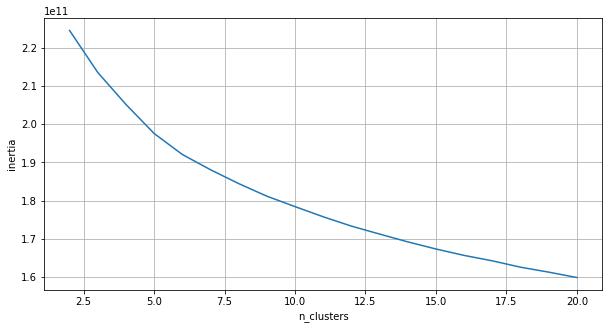

In [150]:
# elbow rule :)
n_clusters = range(2,21)
inertia = [KMeans(n_clusters=n).fit(X).inertia_ for n in n_clusters]
plt.figure(figsize=(10,5))
plt.plot(n_clusters, inertia)
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.grid();

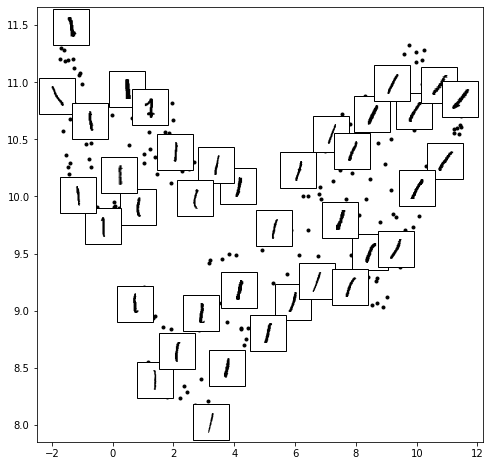

In [9]:
plot_components(X[y == 1][::30])

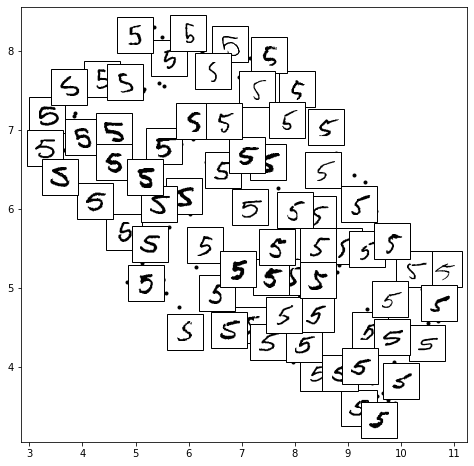

In [10]:
plot_components(X[y == 5][::30])

In [45]:
# dimensionality reduction
X_pca_150 = PCA(n_components=150, random_state=42).fit_transform(X)
X_pca_2 = PCA(n_components=2, random_state=42).fit_transform(X)
X_lsa_2 = TruncatedSVD(n_components=2, random_state=42).fit_transform(X)
X_umap_2_10 = UMAP(n_neighbors=10, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)
X_umap_2_30 = UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)

CPU times: user 54.2 ms, sys: 690 µs, total: 54.9 ms
Wall time: 52.6 ms


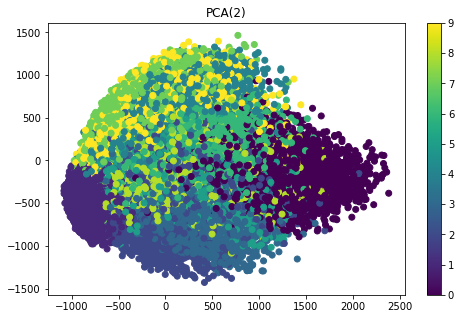

In [46]:
%%time
# PCA(2)
scatter_2dim(X_pca_2, y, 'PCA(2)')

CPU times: user 53.1 ms, sys: 350 µs, total: 53.5 ms
Wall time: 52.7 ms


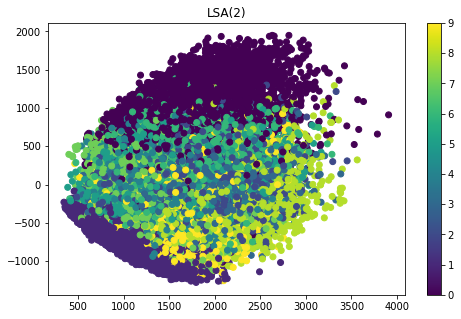

In [47]:
%%time
# LSA(2)
scatter_2dim(X_lsa_2, y, 'LSA(2)')

CPU times: user 54 ms, sys: 602 µs, total: 54.6 ms
Wall time: 53.1 ms


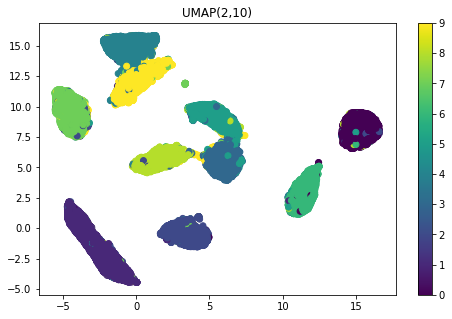

In [48]:
%%time
# UMAP(2,10)
scatter_2dim(X_umap_2_10, y, 'UMAP(2,10)')

CPU times: user 50.4 ms, sys: 723 µs, total: 51.1 ms
Wall time: 49.3 ms


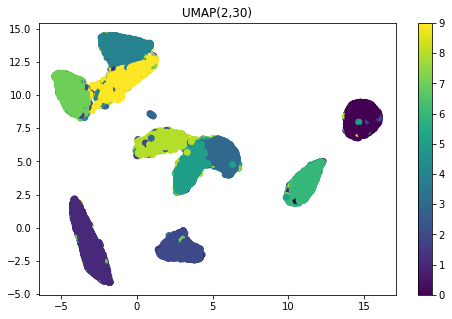

In [49]:
%%time
# UMAP(2,30)
scatter_2dim(X_umap_2_30, y, 'UMAP(2,30)')

X.shape: (70000, 784)
X_projected.shape: (70000, 2)
accuracy_score: 0.967
silhouette_score: 0.666
homogeneity_score: 0.915
completeness_score: 0.916
v_measure_score: 0.916
CPU times: user 1min 45s, sys: 1min 18s, total: 3min 3s
Wall time: 1min 3s


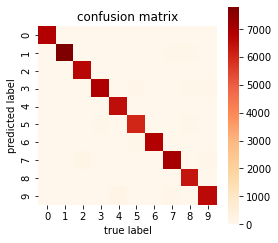

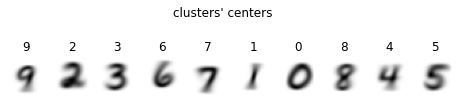

In [50]:
%%time
# UMAP(2) + MiniBatchKMeans
km = MiniBatchKMeans(n_clusters=10, n_init=10, random_state=1)
clusters = km.fit_predict(X_umap_2_10)
show_report(X, y, X_umap_2_10, clusters)

[-1  0  1  2  3  4  5  6  7  8  9] 845
0.958
X.shape: (69155, 784)
X_projected.shape: (69155, 2)
accuracy_score: 0.970
silhouette_score: 0.639
homogeneity_score: 0.921
completeness_score: 0.921
v_measure_score: 0.921
CPU times: user 1min 41s, sys: 1min 13s, total: 2min 54s
Wall time: 1min 3s


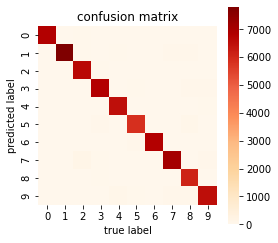

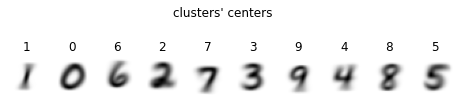

In [51]:
%%time
# UMAP(2) + HDBSCAN
dbscan = HDBSCAN(min_cluster_size=500, min_samples=10)
clusters = dbscan.fit_predict(X_umap_2_30)
print(np.unique(clusters), np.sum(clusters == -1))

p = np.zeros_like(clusters)

for c in range(10):
    if np.sum(clusters == c):
        p[clusters == c] = mode(y[clusters == c])[0][0]

print(np.around(np.mean(p == y), 5))
show_report(X[clusters != -1], y[clusters != -1], X_umap_2_30[clusters != -1], clusters[clusters != -1])